<font color='red'> Если нет необходимых библиотек инсталируем их </font>

In [267]:
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
import torchvision.datasets
import torchvision.transforms as torch_T
from PIL import Image

# Лабораторная №1

In [239]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [240]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels

C:\Users\Kirill\.conda\envs\bayes\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Kirill\.conda\envs\bayes\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [241]:
X_train = X_train.float().numpy()

In [242]:
X_train.shape

(60000, 28, 28)

# Выбор варианта

Всего 60000 картинок, каждый выбирает картинки из диапазона $[6000(n-1)+1,6000\cdot n]$ где $n$- номер по списку.
Постройте гистограмму для ответов (y_train) и убедитесь, что у вас нет дисбаланса классов. Если есть дисбаланс, устраните его удалением соответствующего класса или удалением картинок. Порог для преобразования в $\{0,1\}$(см. ниже) установите равным:
$$
thr = 0.45 + (n-1)/100
$$

## Преобразуем данные в нули и единицы.

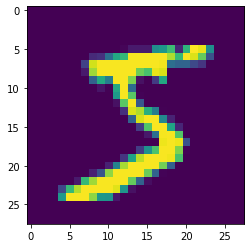

In [243]:
plt.imshow(X_train[0, :, :])
plt.show()

In [244]:
thr = 0.45 # Номер варианта см. список группы
X_train[X_train>thr] = 1
X_train[X_train<thr] = 0

## Картинка после преобразования

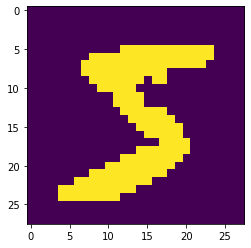

tensor(5)


In [245]:
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

## Применим EM-алгоритм для смеси распределений Бернулли

Найти выражения для E-шага и M-шага для смеси C штук распределений
Бернулли 
$$
p(X\mid \theta) = \prod_{i=1}^D \sum_{c=1}^C p (x_i|\mu_c)\pi_c, \quad x_i\in \mathbf{R}^N,  \quad \mu\in\mathbf{R}^N
$$
$$
p(z\mid\mu_c) = \prod_{j=1}^N \mu_{cj}^{z_j}(1-\mu_{cj})^{1-z_j}, \quad  z_j\in\{0,1\},
$$

где параметры модели $\theta = \{\mu_{11},\dots,\mu_{1N},\dots,\mu_{C1},\dots,\mu_{CN}, \pi_1,\dots, \pi_C\}$. 

<font color='red'> В отличие от модели на семинаре здесь параметр $\mu$ это вектор размера $N$ !!! </font>

## Задание 1: получить выражения для E-шага


Получить формулы для E-шага. 
$$
q(t_i) = p (t_i\mid x_i,\theta)
$$
$$
\gamma_{i,c} = q(t_i=c) = \dots
$$


<b>Важный трюк 1:</b> при вычислении произведений, можно использовать логарифмирование, при этом, чтобы избежать нулей под логарифмом, можно нули заменять на очень маленькие числа. 

<b>Важный трюк 2:</b> важно избегать числовых ошибок. В какой-то момент вам может понадобиться вычислить формулу следующего вида (если использовать логарифмирование (см. трюк 1)): $\frac{e^{y_i}}{\sum_j e^{y_j}}$, которая называется _softmax_. Когда вы вычисляете показатели степени больших чисел, некоторые числа могут стать бесконечными. Этого можно избежать, разделив числитель и знаменатель на $e^{\max(y)}$: 
$$
\frac{e^{y_i-\max(y)}}{\sum_j e^{y_j - \max(y) )}}.
$$ 
После этого преобразования максимальное значение в знаменателе будет равно единице. Все остальные члены будут вносить меньшие значения. Итак, чтобы вычислить нужную формулу, вы сначала вычитаете максимальное значение из каждой компоненты в векторе $\mathbf{y}$, а затем вычисляете все остальное, как и раньше.


## Задание 2: реализовать E-шаг

In [246]:


def E_step(X, pi, mu):
        
    eps = 1e-12


    def G_c_i(xi, pc, mc):
        sum_ = 0
        for j, x in enumerate(xi):
            val = x * np.log(mc[j] + eps) + (1 - x) * np.log(1 - mc[j] + eps)
            sum_ += val
        sum_ += np.log(pc + eps)
        return sum_

    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (D x N), data points
    pi: (C), mixture component weights 
    mu: (C x N), mixture component means
    
    Returns:
    gamma: (C x D), probabilities of clusters for objects
    """
    D = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    N = mu.shape[1] # dimension of each object
    gamma = np.zeros((C, D)) # distribution q(T)
    log_g = np.zeros((C, D))
    for c in range(C):
        for i in range(D):
            log_g[c][i] = G_c_i(X[i], pi[c], mu[c])
    
    M = np.zeros(D)
    for i in range(D):
        max_ = -1e6
        for c in range(C):
            if(max_ < log_g[c][i]):
                max_ = log_g[c][i]
        M[i] = max_


    EXP =np.zeros((C, D))

    for c in range(C):
        for i in range(D):
            e_ = log_g[c][i] - M[i]
            ex_ = np.exp(e_)
            EXP[c][i] = ex_
    
    s = 1

    for c in range(C):
        for i in range(D):
            sum_e = EXP.T[i].sum()
            ga_c_i =EXP[c][i] / (sum_e + eps)
            gamma[c][i] = ga_c_i

    
    #TO DO
    return gamma

## Задание 3:  получить выражения для M-шаг


$$
{\cal L}(\theta,q) = \sum_i\sum_c \gamma_{i,c}\left(\sum_{j=1}^N x_{ij}\log(\mu_{cj}) + (1-x_{ij})\log(1-\mu_{cj})+ \log\pi_c\right) \to \max_{\theta}
$$

Составить функцию Лагранжа и получить выражения для $\theta$.

## Задание 4: реализовать M-шаг

In [247]:
np.array([1]).sum()

1

In [248]:
def M_step(X, gamma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (D x N), data points
    gamma: (C x D), probabilities of clusters for objects
    Returns:
    pi: (C)
    mu: (C x N)
    """
    D = X.shape[0] # number of objects
    C = gamma.shape[0] # number of clusters
    N = X.shape[1] # dimension of each object
    #TO DO
    pi = np.zeros(C)
    mu = np.zeros((C, N))
    for c in range(C):
        val = gamma[c].sum() / gamma.sum()
        pi[c] = val
        for j in range(N):
            m_ = (gamma[c] @  X.T[j]) / gamma[c].sum()
            mu[c][j] = m_
    

    return pi, mu

## Задание 5: получить функцию потерь

Наконец, нам нужна функция для отслеживания сходимости. Для этой цели мы будем использовать вариационную нижнюю границу $\mathcal{L}$. Мы остановим наши итерации EM, когда $\mathcal{L}$ перестанет сильно изменяться.  Также полезно проверить, что эта функция никогда не уменьшается во время тренировки. Если это так, у вас есть ошибка в вашем коде.

<b>Реализуем функцию, которая будет вычислять $\mathcal{L}$</b> 

$$\mathcal{L}(\theta, q) =\mathbb{E}_{q(T)}\log \frac{p(X,T | \theta)}{q(T|\theta)}  =  \dots$$ 

## Задание 6: реализовать функцию потерь

Не забываем использовать <b>трюк 1</b>.


$$
{\cal L}(\theta,q) = \sum_c\sum_i \gamma_{c,i}\left(\sum_{j=1}^N x_{ij}\log(\mu_{cj}) + (1-x_{ij})\log(1-\mu_{cj})\right)+ \log\pi_c \to \max_{\theta}
$$



In [249]:
def compute_vlb(X, pi, mu, gamma):
    """
    Each input is numpy array:
    X: (D x N), data points
    gamma: (C x D), distribution q(T)  
    pi: (C)
    mu: (C x N)
    sigma: (C x N x N)
    
    Returns value of variational lower bound
    """
    D = X.shape[0] # number of objects
    C = gamma.shape[0] # number of clusters
    N = X.shape[1] # dimension of each object
    eps =1e-9
    #TO DO

    loss = 0
    for c in range(C):
        for i in range(D):
            sum_ = 0
            for j in range(N):
                sum_ += X[i][j] * np.log(mu[c][j] + eps) + (1 - X[i][j]) * np.log(1 - mu[c][j] + eps)

            loss += sum_+ np.log(pi[c] + eps)

  

    return loss

## Задание 7: внедрение процедуры обучения

Теперь, когда у нас есть шаг E, шаг M и VLB, мы можем реализовать тренировочный цикл. Мы будем инициализировать значения $\pi$, $\mu$ и $\Sigma$ некоторыми случайными числами, обучать до тех пор, пока $\mathcal{L}$ не перестанет меняться, и возвращать полученные точки. Мы также знаем, что алгоритм EM сходится к локальным оптимумам. Чтобы найти лучшие локальные оптимумы, мы перезапустим алгоритм несколько раз с разных (случайных) начальных позиций. Каждое тренировочное испытание должно останавливаться либо при достижении максимального количества итераций, либо когда относительное улучшение становится меньше заданного допуска $$\left|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal {L}_{i-1}}\right| \le \text{rtol}$$.

<b>Начальные данные:</b>
Параметры $\pi_c$ можно задавать одинаковыми, при это не забываем, что сумма равна единице.  Параметры $\mu$ можно моделировать равномерно на отрезке [0.25, 0.75], далее их надо отнормировать.

Также в код можно добавить обработку ситуации, когда целевая функция возвращает nan.

In [250]:
def rand_pi(C):
    pi = np.zeros(C)
    #TO DO
    return pi

def rand_mu(X, C, N):
    #print('\n', type(X), '\n', type(C), '\n', type(N))
    mu = np.ones((C,N))
    mu = np.abs(np.random.normal(size=(C, N)))
    mu /= mu.sum()
    # TO DO
    return mu


def train_EM(X, C=10, rtol=1e-3, max_iter=10, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (D, N), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None
    loss_prev = None
    losses = []
    
    

    for _ in range(restarts):
        print('New restart')
        loss = None
        curr_rel_loss = None
        pic = np.abs(np.random.normal(size=C))
        pi0 = pic / pic.sum()
        mu0 = rand_mu(X, C, N) 
        loss = None
        for i in range(max_iter):
            pi, mu = pi0, mu0
            gamma = E_step(X, pi, mu)
            pi, mu  = M_step(X, gamma)
            loss = compute_vlb(X, pi, mu, gamma)
            losses.append(loss)
            pi0 = pi
            mu0 = mu
            if loss_prev != None:
                curr_rel_loss = np.abs(loss_prev - loss)/np.abs(loss_prev)
                loss_prev = loss
            else:
                loss_prev = loss
            if curr_rel_loss!=None and curr_rel_loss < rtol:
                break
            print(f'Step: {i}')
        if best_loss!=None:
            if loss>best_loss:
                best_loss = loss
                best_mu = mu
                best_pi = pi
        else:
            best_loss = loss
            best_mu = mu
            best_pi = pi

    return  losses, best_pi, best_mu

In [251]:
X_train[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1

In [254]:
losses, pi, mu = train_EM(X_train[0])

New restart
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
New restart
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
New restart
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
New restart
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
New restart
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
New restart
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
New restart
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
New restart
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
New restart
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
New restart
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9


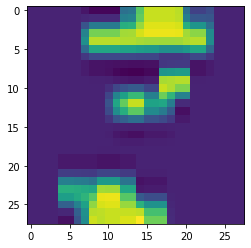

In [272]:
plt.imshow(np.array(Image.fromarray(mu).resize(size = (28, 28))))

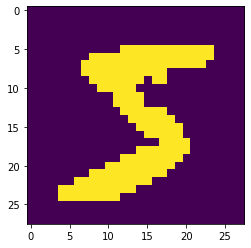

In [259]:
plt.imshow(X_train[0])

## Задание 8

Обучить модель и ответить на следующие вопросы.

1. Построить графики для всех математических ожиданий в виде цифр (т.е. преобразовать вектора в матрицы) Похожи ли получившиеся средние на цифры? (С=10)
2. Построить несколько картинок для цифр из обучающей выборки и соответствующих математических ожиданий на одном графике для одного класса. Проделать это для нескольких классов. Как можно интерпретировать результат?
3. Разбить на обучающую и тестовую выборки, и определить оптимальное кол-во кластеров с помощью графиков правдоподобия для обучения и теста. 
4. Попробовать улучшить результат (варьировать различные параметры), подумать как оценивать качество.
5. Написать вывод.
